In [1]:
import gym
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
import os
import datetime
import random
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [2]:
tf.keras.backend.set_floatx('float32')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
problem = "Pendulum-v1"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  3
Size of Action Space ->  1
Max Value of Action ->  2.0
Min Value of Action ->  -2.0


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [5]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [6]:
problem = "Pendulum-v1"
env = gym.make(problem)

env = env
SEASONS = 1000
episode = 0
replay_count = 0
success_value = 70
lr_a = 0.0002
lr_c = 0.0002
epochs = 10
training_batch = 1024
batch_size = 128
epsilon = 0.2
gamma = 0.993
lmbda = 0.7
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
critic_optimizer = tf.keras.optimizers.Adam(lr_a)
actor_optimizer = tf.keras.optimizers.Adam(lr_c)
baseline_optimizer = tf.keras.optimizers.Adam(lr_c)
total_episodes = 100
gamma = 0.99
tau = 0.005

In [7]:
def get_actor(env):
    state_size = env.observation_space.shape
    action_size = env.action_space.shape[0]
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = tf.keras.layers.Input(shape = state_size)
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

In [8]:
def train_actor(states, advantages, actions, actor, epsilon, 
                action_size, optimizer, old_pi, critic, b, s_batch):
      with tf.GradientTape() as tape:
        mean = tf.squeeze(actor(states))

        logstd = tf.Variable(np.zeros(shape=env.action_space.shape[0], 
                                      dtype=np.float32))
        std = tf.squeeze(tf.exp(logstd))
        new_pi = tfp.distributions.Normal(mean, std)

        ratio = tf.exp(new_pi.log_prob(tf.squeeze(actions)) -
                          old_pi.log_prob(tf.squeeze(actions)))

        adv_stack = tf.stack([advantages for _ in range(action_size)], axis=1)
        p1 = ratio * adv_stack
        p2 = tf.clip_by_value(ratio, 1. - epsilon, 1. + epsilon) * adv_stack
        ppo_loss = K.mean(K.minimum(p1, p2))

        mean_off = actor(s_batch)
        q_values = critic([s_batch, mean_off])
        sum_q_values = K.sum(K.mean(q_values))
        off_loss = ((b / len(s_batch)) * sum_q_values)

        actor_loss = -tf.reduce_sum(ppo_loss + off_loss)
        actor_weights = actor.trainable_variables

        actor_grad = tape.gradient(actor_loss, actor_weights)
        optimizer.apply_gradients(zip(actor_grad, actor_weights))

        return actor_loss.numpy()

In [9]:
def get_critic(env):
    state_size = env.observation_space.shape
    action_size = env.action_space.shape[0]
    upper_bound = env.action_space.high[0]
    lr = 0.0002 
    gamma = 0.993
    train_step_count = 0
    optimizer = tf.keras.optimizers.Adam(lr)

    state_input = layers.Input(shape=state_size)
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    action_input = layers.Input(shape=(action_size))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    model = tf.keras.Model([state_input, action_input], outputs)
    
    return model

In [10]:
def train_critic(state_batch, action_batch, critic, optimizer, y):
      with tf.GradientTape() as tape:
        critic_weights = critic.trainable_variables
        critic_value = critic([state_batch, action_batch])
        critic_loss = tf.math.reduce_mean(tf.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_weights)
        optimizer.apply_gradients(zip(critic_grad, critic_weights))
        return critic_loss

In [11]:
def get_baseline(env):
    state_size = env.observation_space.shape
    action_size = env.action_space.shape[0]

    lr = 0.0002
    optimizer = tf.keras.optimizers.Adam(lr)

    state_input = tf.keras.layers.Input(shape=state_size)
    f = tf.keras.layers.Dense(128, activation="relu", trainable=True)(state_input)

    out = tf.keras.layers.Dense(128, activation="relu", trainable=True)(f)
    out = tf.keras.layers.Dense(64, activation="relu", trainable=True)(out)
    out = tf.keras.layers.Dense(32, activation="relu", trainable=True)(out)
    net_out = tf.keras.layers.Dense(1, trainable=True)(out)

    model = tf.keras.Model(inputs=state_input, outputs=net_out)

    return model

In [12]:
def train_baseline(states, baseline, optimizer, returns):
    
  with tf.GradientTape() as tape:
      critic_weights = baseline.trainable_variables
      critic_values = baseline(states)
      critic_loss = tf.math.reduce_mean(tf.square(returns - critic_values))

  critic_grad = tape.gradient(critic_loss, critic_weights)
  optimizer.apply_gradients(zip(critic_grad, critic_weights))
  return critic_loss.numpy()


In [13]:
def policy(actor, state, noise_object):
    sampled_actions = tf.squeeze(actor(state))
    noise = noise_object()

    sampled_actions = sampled_actions.numpy() + noise

    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    return [np.squeeze(legal_action)]

In [14]:
def compute_advantages(baseline, r_batch, s_batch, ns_batch, d_batch):
  gamma = 0.99
  lmbda = 0.7

  s_values = tf.squeeze(baseline(s_batch))
  ns_values = tf.squeeze(baseline(ns_batch))
  returns = []
  gae = 0
  for i in reversed(range(len(r_batch))):
      delta = r_batch[i] + gamma * ns_values[i] * (1 - d_batch[i]) - s_values[i]
      gae = delta + gamma * lmbda * (1 - d_batch[i]) * gae
      returns.insert(0, gae + s_values[i])

  returns = np.array(returns)
  # Q - V
  adv = returns - s_values.numpy()  
  adv = (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
  return adv, returns

In [15]:
def compute_targets(actor, critic, r_batch, ns_batch, d_batch):
  gamma = np.float32(0.99)
  mean = actor(ns_batch)

  target_critic_1 = critic([ns_batch, mean])

  r_batch = tf.cast(r_batch, dtype=tf.float32)
  d_batch = tf.cast(d_batch, dtype=tf.float32)
  target_critic_1 = tf.cast(target_critic_1, dtype=tf.float32)

  y = r_batch + gamma * (1 - d_batch) * target_critic_1
  return y

In [16]:
def compute_adv_bar(actor, critic, s_batch, a_batch):
  mean = actor(s_batch)
  x = tf.squeeze(a_batch) - tf.squeeze(mean)
  y = tf.squeeze(critic([s_batch, mean]))
  adv_bar = y * x

  return adv_bar

In [17]:
def replay(actor, critic, baseline, states, actions, rewards, dones, next_states):

  a_loss_list = []
  c_loss_list = []

  n_split = len(rewards)

  states = tf.convert_to_tensor(states, dtype=tf.float32)
  actions = tf.convert_to_tensor(actions, dtype=tf.float32)
  rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
  dones = tf.convert_to_tensor(dones, dtype=tf.float32)
  next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
  advantages, returns = compute_advantages(baseline, rewards, states, next_states, dones)

  b = 0
  use_CV = False
  v = 0.2
  if use_CV:
      adv_bar = compute_adv_bar(states, actions)
      ls = advantages - adv_bar
      b = 1
  else:
      ls = advantages
      b = v

  ls *= (1 - v)

  s_split = tf.split(states, n_split)
  a_split = tf.split(actions, n_split)
  t_split = tf.split(returns, n_split)
  adv_split = tf.split(advantages, n_split)
  ls_split = tf.split(ls, n_split)
  indexes = np.arange(n_split, dtype=int)


  mean = tf.squeeze(actor(states))
  logstd = tf.Variable(np.zeros(shape=env.action_space.shape[0], dtype=np.float32))
  std = tf.squeeze(tf.exp(logstd))
  pi = tfp.distributions.Normal(mean, std)

  a_loss, c_loss = 0, 0

  np.random.shuffle(indexes)
  for _ in range(epochs):
      s_batch, a_batch, r_batch, ns_batch, d_batch = buffer.sample()
      for i in indexes:
          old_pi = pi[i * batch_size: (i + 1) * batch_size]
          a_loss = train_actor(s_split[i], ls_split[i], a_split[i], actor, 0.2, num_actions, actor_optimizer, old_pi, critic, b, s_batch)
          a_loss_list.append(a_loss)
          v_loss = train_baseline(s_split[i], baseline, baseline_optimizer, t_split[i])

      y = compute_targets(actor, critic, r_batch, ns_batch, d_batch)
      c_loss = train_critic(s_batch, a_batch, critic, critic_optimizer, y)

      c_loss_list.append(c_loss)

      return np.mean(a_loss_list), np.mean(c_loss_list)

In [18]:
# Validation Routine
def validate(self, env, max_eps=50):
  ep_reward_list = []
  for ep in range(max_eps):
      if self.is_mujo:
          state = env.reset()["observation"]
      else:
          state = env.reset()
          state = np.asarray(state, dtype=np.float32)
      t = 0
      ep_reward = 0
      while True:
          action = policy(actor, tf_prev_state, ou_noise)
          next_obsv, reward, done, _ = env.step(action)
          next_state = np.asarray(next_obsv, dtype=np.float32)
          state = next_state
          ep_reward += reward
          t += 1
          if done:
              ep_reward_list.append(ep_reward)
              break

  mean_ep_reward = np.mean(ep_reward_list)
  return mean_ep_reward

In [19]:
class Buffer:
    def __init__(self, actor, critic, buffer_capacity=100000, batch_size=64):
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size

        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.done_batch = np.zeros((self.buffer_capacity, num_states))


    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.done_batch[index] = obs_tuple[4]

        self.buffer_counter += 1

    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):

        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor(state_batch, training=True)
            critic_value = critic([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor.trainable_variables)
        )

    def learn(self):
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)

    def sample(self):
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        done_batch = tf.convert_to_tensor(self.done_batch[batch_indices])

        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

In [21]:
def save_model(self, path, actor_filename, critic_filename, baseline_filename):
  actor_file = path + actor_filename
  critic_file = path + critic_filename
  baseline_file = path + baseline_filename
  self.actor.save_weights(actor_file)
  self.critic.save_weights(critic_file)
  self.baseline.save_weights(baseline_file)

In [22]:
def load_model(self, path, actor_filename, critic_filename, baseline_filename):
  actor_file = path + actor_filename
  critic_file = path + critic_filename
  baseline_file = path + baseline_filename
  self.actor.model.load_weights(actor_file)
  self.critic.model.load_weights(critic_file)
  self.baseline.model.load_weights(baseline_file)

In [24]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor = get_actor(env)
critic = get_critic(env)
baseline = get_baseline(env)

target_actor = get_actor(env)
target_critic = get_critic(env)

target_actor.set_weights(actor.get_weights())
target_critic.set_weights(critic.get_weights())

critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
gamma = 0.99
tau = 0.005

buffer = Buffer(50000, 64)

Episode * 0 * Avg Reward is ==> -887.4319659723542
Episode * 1 * Avg Reward is ==> -1621.5889501912075
Episode * 2 * Avg Reward is ==> -1528.846574201716
Episode * 3 * Avg Reward is ==> -994.468384171855
Episode * 4 * Avg Reward is ==> -1389.449864769489
Episode * 5 * Avg Reward is ==> -1257.0851827943468
Episode * 6 * Avg Reward is ==> -1176.2907017757475
Episode * 7 * Avg Reward is ==> -1318.3158780987826
Episode * 8 * Avg Reward is ==> -915.5993996938274
Episode * 9 * Avg Reward is ==> -1521.7604565966608
Episode * 10 * Avg Reward is ==> -1075.1015346964475
Episode * 11 * Avg Reward is ==> -1188.3927155761683
Episode * 12 * Avg Reward is ==> -1139.2523078594254
Episode * 13 * Avg Reward is ==> -1145.260635097315
Episode * 14 * Avg Reward is ==> -1521.7428333666587
Episode * 15 * Avg Reward is ==> -1260.5694938525169
Episode * 16 * Avg Reward is ==> -1105.9636658709965
Episode * 17 * Avg Reward is ==> -1216.673088017887
Episode * 18 * Avg Reward is ==> -1024.411385303148
Episode * 19

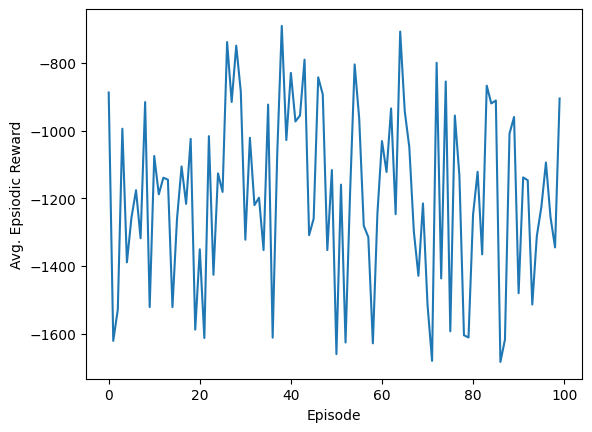

In [26]:
state = env.reset()
state = np.asarray(state, dtype=np.float32)
done, score = False, 0
best_score = -np.inf
val_score = -np.inf
val_scores = deque(maxlen=50)
s = 0
s_scores = deque(maxlen=50)

avg_reward_list = []

for ep in range(100):
  state = env.reset()
  episodic_reward = 0
  s_score = 0
  states, next_states, actions, rewards, dones = [], [], [], [], []
  ep_reward_list = []
  

  while True:
      tf_prev_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
      action = policy(actor, tf_prev_state, ou_noise)
      
      next_state, reward, done, info = env.step(action)

      next_state = np.asarray(next_state, dtype=np.float32)
      states.append(state)
      next_states.append(next_state)
      actions.append(action)
      rewards.append(reward)
      dones.append(done)

      buffer.record((state, action, reward, next_state, done))
      episodic_reward += reward

      if done:
        state, done, score = env.reset(), False, 0
        state = np.asarray(state, dtype=np.float32)
        break

      state = next_state
      ep_reward_list.append(episodic_reward)

  avg_reward = np.mean(ep_reward_list[-40:])
  print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
  avg_reward_list.append(avg_reward)

  a_loss, c_loss = replay(actor, critic, baseline, states, actions, rewards, dones, next_states)

env.close()

plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()
  